# Accuracy Report
This notebook provides a visual analysis of the extraction accuracy compared to the ground truth across multiple documents.

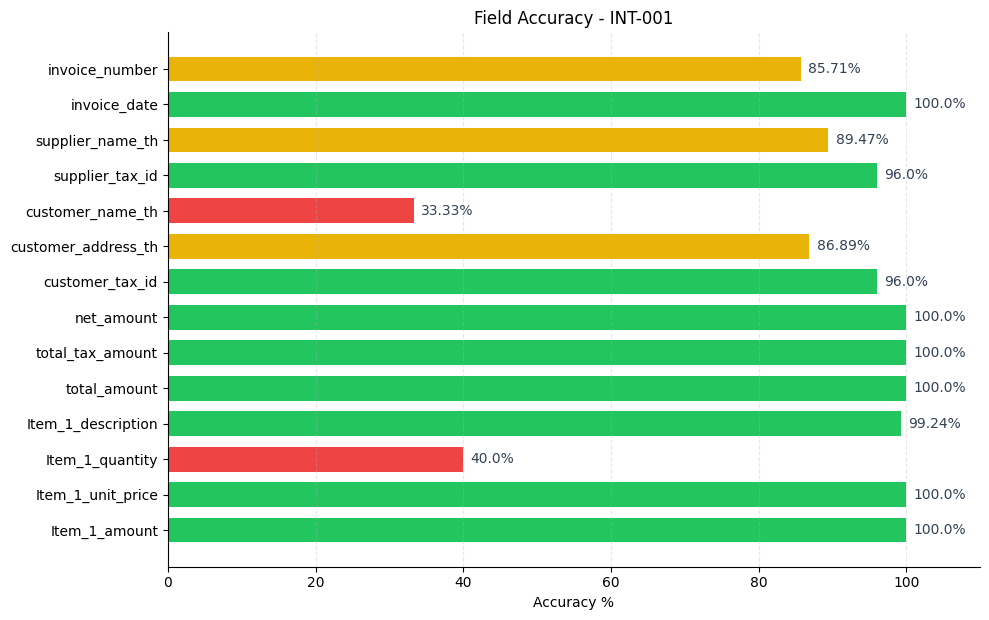

,Field,Accuracy,Ground Truth,Result,Category
0,invoice_number,85.71%,25102400095,2510260095,Header
1,invoice_date,100.00%,24/10/2025,24/10/2025,Header
2,supplier_name_th,89.47%,บริษัท อินเทอร์เน็ตประเทศไทย จำกัด (มหาชน),บริษัท อินเทอร์เน็ตประเทศไทย จำกัด,Header
3,supplier_tax_id,96.00%,0107544000094,010754400094,Header
4,customer_name_th,33.33%,บจก. อินโนเวทีฟ เอ็กซ์ตรีมิสต์,บมจ. อินเทอร์เน็ต โซลูชั่นส์ คอร์เปอเรชั่น,Header
5,customer_address_th,86.89%,เลขที่ 3 อาคาร พร้อมพันธุ์ 3 ห้องเลขที่ 1608-1614 ชั้นที่ 16 ซอย ลาดพร้าว 3 ถนน ลาดพร้าว แขวง จอมพล เขต จตุจักร กรุงเทพมหานคร 10900,เลขที่ 3 อาคาร พร้อมพื้นที่ 3 ห้องเลขที่ 1608-1614 ชั้นที่ 16 ซอย ลาดพร้าว 3 ถนน สาทรปราเวศ แขวง ฉัตรชัย เขต จตุจักร กรุงเทพมหานคร 10900,Header
6,customer_tax_id,96.00%,0105551117714,010551117714,Header
7,net_amount,100.00%,600.00,600.00,Header
8,total_tax_amount,100.00%,42.00,42.00,Header
9,total_amount,100.00%,642.00,642.00,Header


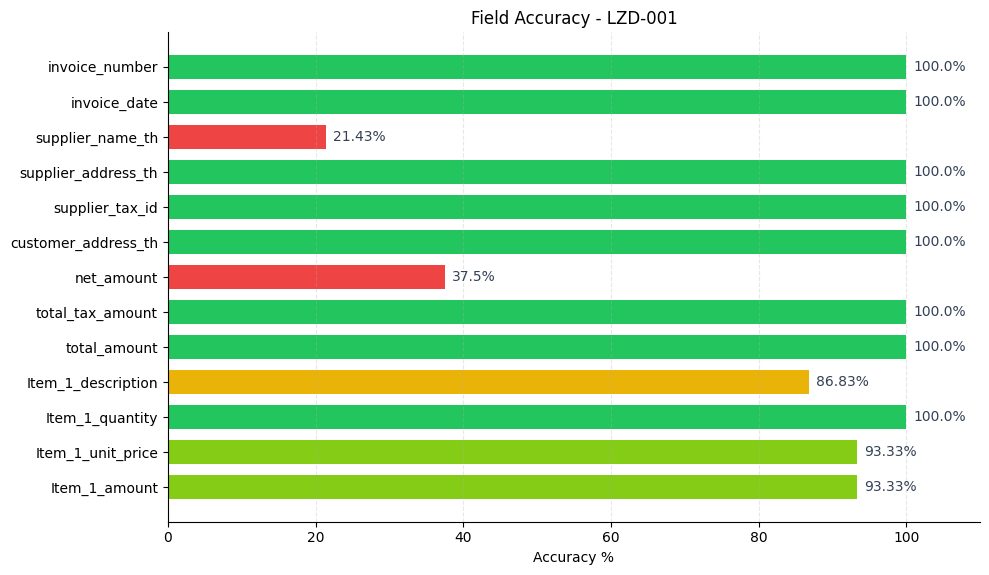

,Field,Accuracy,Ground Truth,Result,Category
0,invoice_number,100.00%,IN0018918431,IN0018918431,Header
1,invoice_date,100.00%,26/01/2023,26/01/2023,Header
2,supplier_name_th,21.43%,LAZADA LIMITED,Lazada Limited,Header
3,supplier_address_th,100.00%,"29th Floor Unit 2901 Bhiraj Tower 689, Sukhumvit Road, North Klongton, Vadhana, Bangkok, 10110","29th Floor Unit 2901 Bhiraj Tower 689, Sukhumvit Road, North Klongton, Vadhana, Bangkok, 10110",Header
4,supplier_tax_id,100.00%,0105555040244,0105555040244,Header
5,customer_address_th,100.00%,"กรุงเทพมหานคร/ Bangkok, 10230","กรุงเทพมหานคร/ Bangkok, 10230",Header
6,net_amount,37.50%,"1,269.00","1,185.98",Header
7,total_tax_amount,100.00%,83.02,83.02,Header
8,total_amount,100.00%,"1,269.00","1,269.00",Header
9,Item_1_description,86.83%,Certainty ผ้าอ้อมผู้ใหญ่แบบเทป เซอร์เทนตี้ อีซี่เทป Easy Tapeราคาประหยัด ลัง Super Save ไซส์ L 96 ชิ้น,Certainly ฝาอ้อมผู้ใหญ่นแบบแพ็ค เชอร์เทนส์ อีฟี่แทป Easy Taperราคาประหยัด สัง Super Save ไซส์ L 96 ชิ้น,Line Item


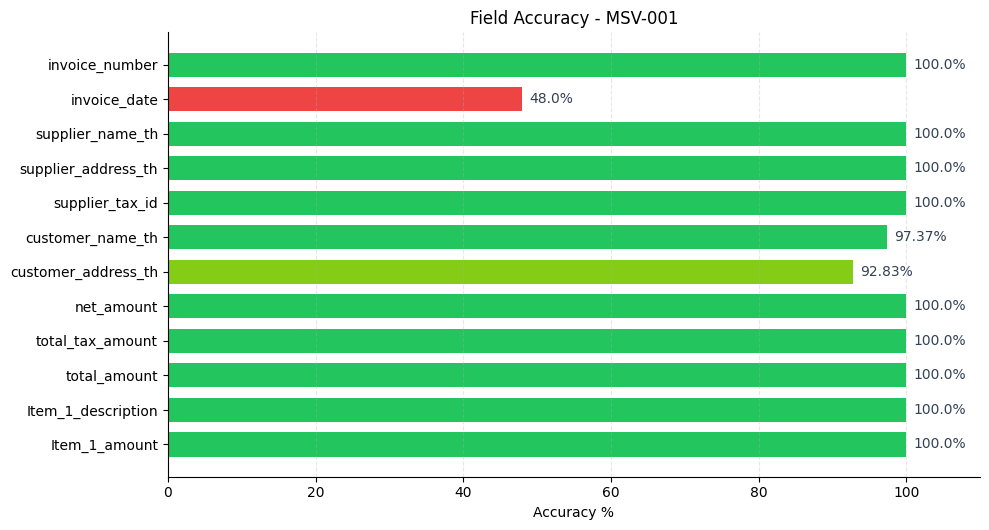

,Field,Accuracy,Ground Truth,Result,Category
0,invoice_number,100.00%,M68/393,M68/393,Header
1,invoice_date,48.00%,17 กันยายน 2568,17/09/2568,Header
2,supplier_name_th,100.00%,บริษัท เอ็ม-เซเว่น (ประเทศไทย) จำกัด,บริษัท เอ็ม-เซเว่น (ประเทศไทย) จำกัด,Header
3,supplier_address_th,100.00%,"309, 311 ซอยอ่อนนุช 70/1 ถนนอ่อนนุช แขวงประเวศ เขตประเวศ กรุงเทพฯ 10250","309, 311 ซอยอ่อนนุช 70/1 ถนนอ่อนนุช แขวงประเวศ เขตประเวศ กรุงเทพฯ 10250",Header
4,supplier_tax_id,100.00%,0105530029573,0105530029573,Header
5,customer_name_th,97.37%,บริษัท อินโนเวทีฟ เอ็กซ์ตรีมิสต์ จำกัด,บริษัท อินโนเวทีฟ เอ็กซ์ตรีมิตส์ จำกัด,Header
6,customer_address_th,92.83%,3 อาคารพร้อมพันธุ์ 3 ชั้นที่ 16 ห้องเลขที่ 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ 10900,ที่อยู่ 3 อาคารพร้อมพื้นที่ 3 ชั้นที่ 16 ห้องเลขที่ 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ 10900,Header
7,net_amount,100.00%,"11,214.95","11,214.95",Header
8,total_tax_amount,100.00%,785.05,785.05,Header
9,total_amount,100.00%,"12,000.00","12,000.00",Header


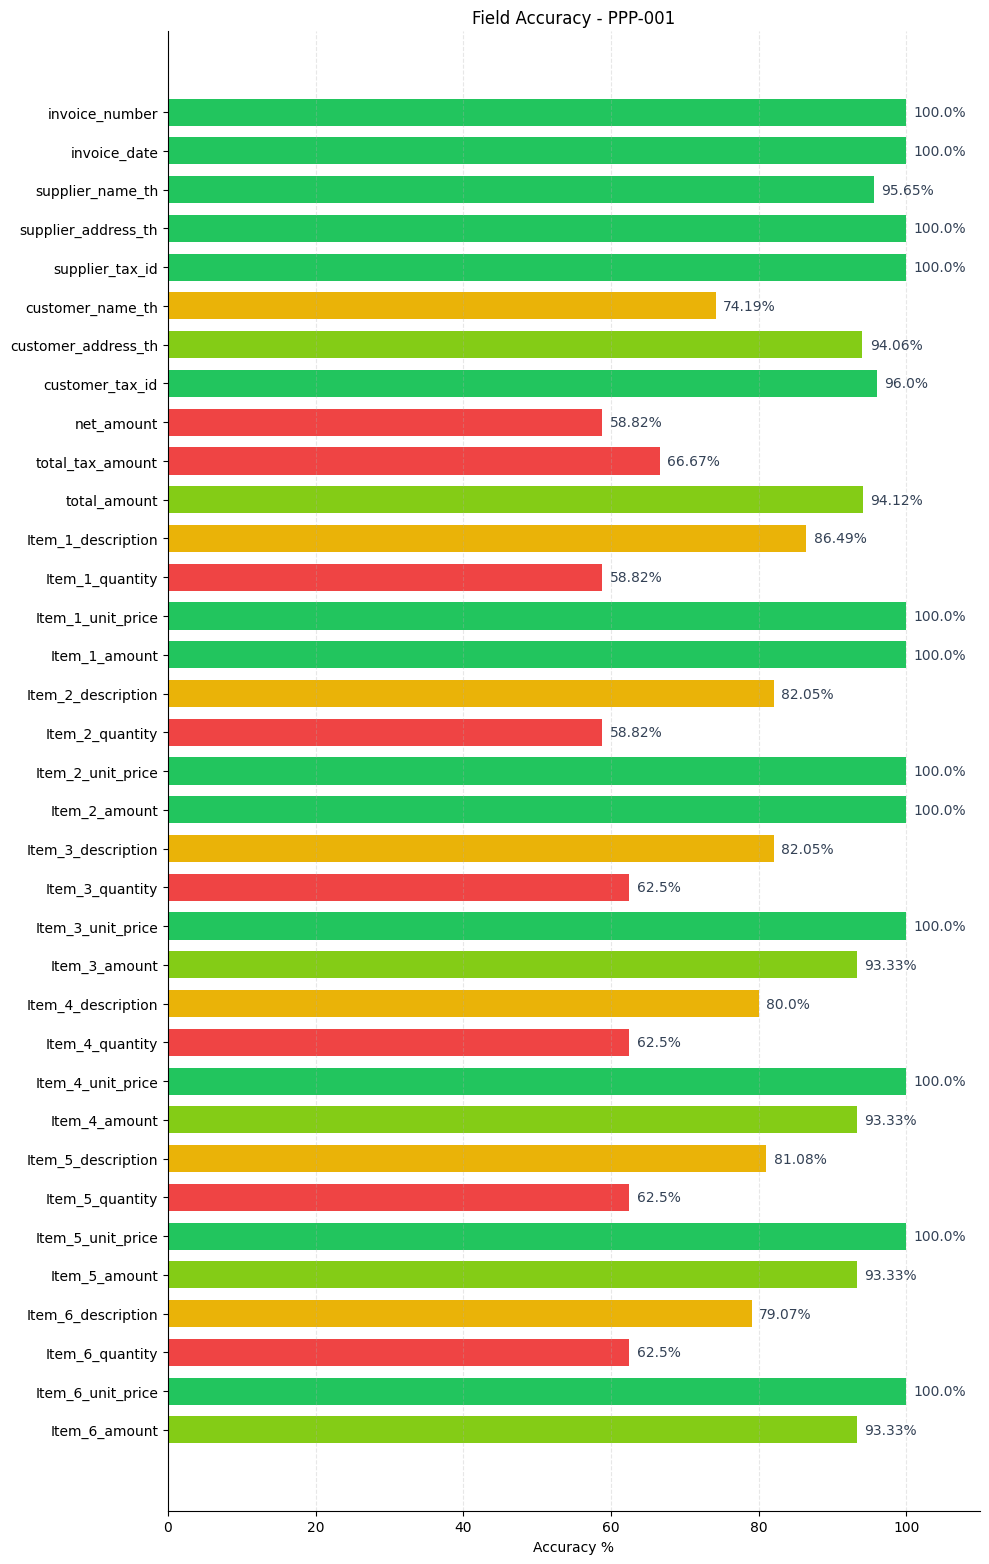

,Field,Accuracy,Ground Truth,Result,Category
0,invoice_number,100.00%,R36810186,R36810186,Header
1,invoice_date,100.00%,07/10/68,07/10/68,Header
2,supplier_name_th,95.65%,บริษัท เพิ่มพูล ประสิทธิ์-ตุ๊ จำกัด,บริษัท เพิ่มพูล ประสิทธิ์-ตี จำกัด,Header
3,supplier_address_th,100.00%,637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900,637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900,Header
4,supplier_tax_id,100.00%,0105534071621,0105534071621,Header
5,customer_name_th,74.19%,บจก. อินโนเวทีฟ เอ็กซ์ตรีมิสต์,บอค. อินโนเวสชั่น เซ็กซ์ตรีมิตส์,Header
6,customer_address_th,94.06%,3 อาคารพร้อมพันธุ์ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900,อาคารพร้อมพื้นที่ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900,Header
7,customer_tax_id,96.00%,0105551117714,010551117714,Header
8,net_amount,58.82%,"11,985.35",11984.41,Header
9,total_tax_amount,66.67%,838.97,839.91,Header


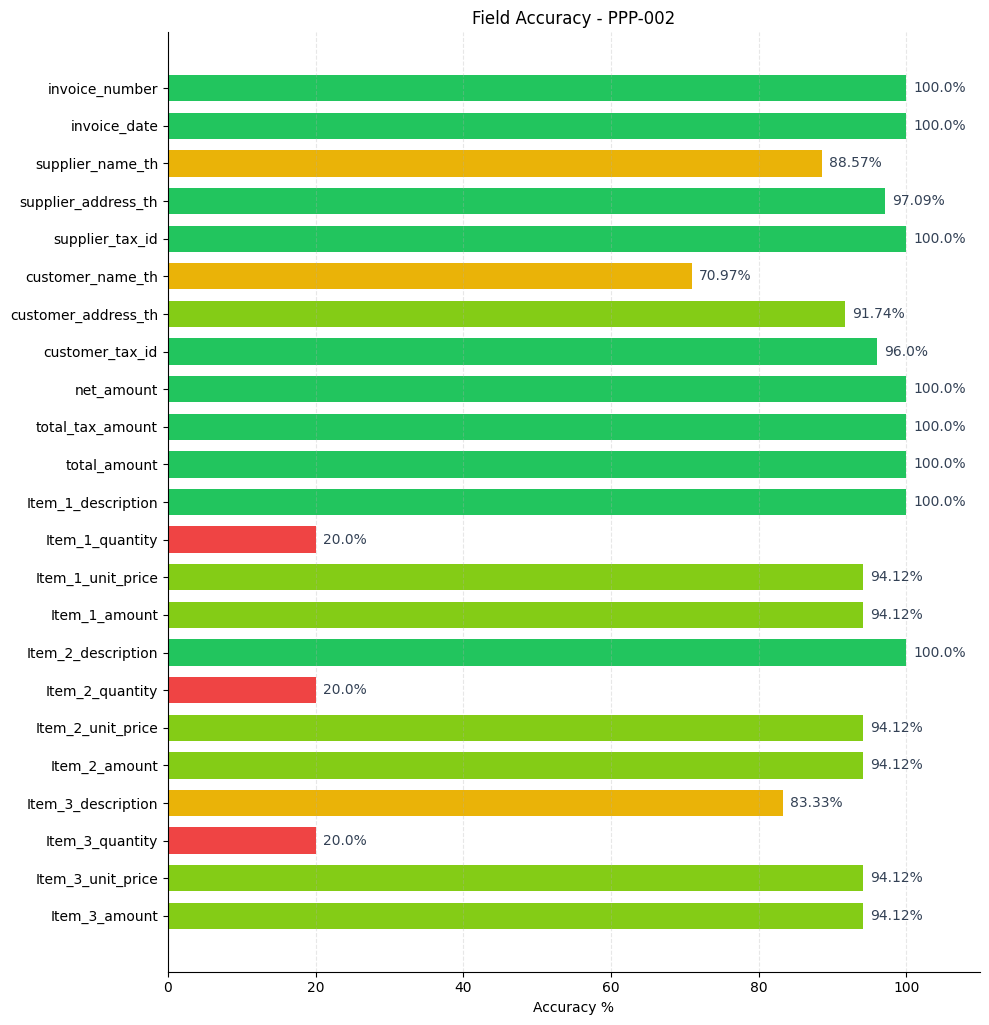

,Field,Accuracy,Ground Truth,Result,Category
0,invoice_number,100.00%,R36810185,R36810185,Header
1,invoice_date,100.00%,07/10/68,07/10/68,Header
2,supplier_name_th,88.57%,บริษัท เพิ่มพูล ประสิทธิ์-ตุ๊ จำกัด,บริษัท เพิ่มพูด ประสิทธิ์-คู่ จำกัด,Header
3,supplier_address_th,97.09%,637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900,"637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ, 10900.",Header
4,supplier_tax_id,100.00%,0105534071621,0105534071621,Header
5,customer_name_th,70.97%,บจก. อินโนเวทีฟ เอ็กซ์ตรีมิสต์,บมจ. อินโนเวสท์ เอ็กซ์เพรเมียนท์,Header
6,customer_address_th,91.74%,3 อาคารพร้อมพันธุ์ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว เเขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900,อาคารพร้อมพื้นที่ ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900,Header
7,customer_tax_id,96.00%,0105551117714,010551117714,Header
8,net_amount,100.00%,"46,700.30","46,700.30",Header
9,total_tax_amount,100.00%,"3,269.02","3,269.02",Header


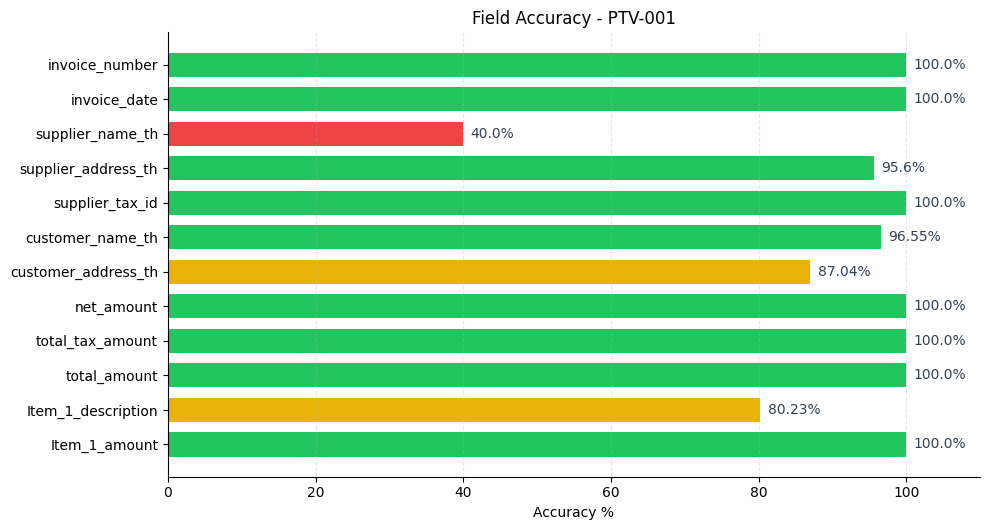

,Field,Accuracy,Ground Truth,Result,Category
0,invoice_number,100.00%,68101365,68101365,Header
1,invoice_date,100.00%,24/10/2025,24/10/2025,Header
2,supplier_name_th,40.00%,บริษัท พันธวณิช จำกัด,พันธวณีย์,Header
3,supplier_address_th,95.60%,1168/94 อาคารลุมพินีทาวเวอร์ ชั้น 31 ถนนพระราม 4 แขวงทุ่งมหาเมฆ เขตสาทร กรุงเทพมหานคร 10120,1168/94 อาคารอสมพินิจาวเวอร์ ชั้น 31 ถนนพระราม 4 แขวงทุ่งมหาเมฆ เขตสาทร กรุงเทพมหานคร 10120,Header
4,supplier_tax_id,100.00%,0105544028248,0105544028248,Header
5,customer_name_th,96.55%,บจ. อินโนเวทีฟ เอ็กซ์ตรีมิสต์,บจ. อินโนเวทีฟ เอ็กซ์ตรีมิตส์,Header
6,customer_address_th,87.04%,3 อาคารพร้อมพันธุ์ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถน นลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ 10900,3 อาคารพร้อมพื้นที่ ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนน ลาภาร้า แขวงแย้มบางพลัด เขตจตุจักร กรุงเทพฯ 10900,Header
7,net_amount,100.00%,"1,740.00","1,740.00",Header
8,total_tax_amount,100.00%,121.80,121.80,Header
9,total_amount,100.00%,"1,861.80","1,861.80",Header


In [5]:
import json
import difflib
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Global list to store summary results
batch_summary = []

def calculate_accuracy(str1, str2):
    str1 = str(str1).strip()
    str2 = str(str2).strip()
    if not str1 and not str2:
        return 100.0
    matcher = difflib.SequenceMatcher(None, str1, str2)
    return round(matcher.ratio() * 100, 2)

def get_comparison_data(gt_path, res_path):
    with open(gt_path, 'r', encoding='utf-8') as f:
        gt = json.load(f)
    with open(res_path, 'r', encoding='utf-8') as f:
        res = json.load(f)

    data = []
    
    # Top-level fields
    for key in gt.keys():
        if key == 'line_items': continue
        val_gt = gt.get(key)
        val_res = res.get(key, "")
        
        if not val_gt or str(val_gt).strip() == "":
            continue
            
        acc = calculate_accuracy(val_gt, val_res)
        data.append({"Field": key, "Accuracy": acc, "Ground Truth": val_gt, "Result": val_res, "Category": "Header"})

    # Line items
    gt_items = gt.get('line_items', [])
    res_items = res.get('line_items', [])
    for i, item_gt in enumerate(gt_items):
        item_res = res_items[i] if i < len(res_items) else {}
        for k, v_gt in item_gt.items():
            if not v_gt or str(v_gt).strip() == "": continue
            v_res = item_res.get(k, "")
            acc = calculate_accuracy(v_gt, v_res)
            data.append({"Field": f"Item_{i+1}_{k}", "Accuracy": acc, "Ground Truth": v_gt, "Result": v_res, "Category": "Line Item"})
            
    return pd.DataFrame(data)

def generate_visual_report(df, filename):
    if df.empty:
        print(f"No data to report for {filename}.")
        return

    overall_acc = df['Accuracy'].mean()
    
    # Store in summary
    batch_summary.append({"File": filename, "Score": overall_acc, "Fields": len(df)})

    display(HTML(f"<h1 style='border-bottom: 2px solid #334155; padding-bottom: 10px; margin-top: 50px;'>Report: {filename}</h1>"))

    # 1. Summary Card
    summary_html = f"""
    <div style="padding: 20px; border-radius: 10px; background-color: #f8fafc; border-left: 8px solid #4CAF50; margin-bottom: 24px; box-shadow: 0 4px 6px -1px rgb(0 0 0 / 0.1);">
        <h2 style="margin: 0; color: #1e293b; font-family: sans-serif;">Extraction Accuracy Summary</h2>
        <div style="display: flex; align-items: center; margin-top: 12px;">
            <span style="font-size: 16px; color: #64748b; margin-right: 8px;">Overall Score:</span>
            <span style="color: #16a34a; font-size: 28px; font-weight: bold;">{overall_acc:.2f}%</span>
        </div>
        <p style="margin: 8px 0 0 0; color: #64748b; font-size: 14px;">Total Fields Evaluated: <b style="color: #334155;">{len(df)}</b></p>
    </div>
    """
    display(HTML(summary_html))

    # 2. Bar Chart
    plt.figure(figsize=(10, len(df) * 0.45))
    colors = ['#22c55e' if x > 95 else '#84cc16' if x > 90 else '#eab308' if x > 70 else '#ef4444' for x in df['Accuracy']]
    plt.barh(df['Field'], df['Accuracy'], color=colors, height=0.7)
    plt.xlabel('Accuracy %')
    plt.title(f'Field Accuracy - {filename}')
    plt.xlim(0, 110)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.gca().invert_yaxis()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    for i, v in enumerate(df['Accuracy']):
        plt.text(v + 1, i, f"{v}%", color='#334155', va='center')
    plt.tight_layout()
    plt.show()

    # 3. Styled Table
    def style_accuracy_col(val):
        if val > 95: bg, text = '#f0fdf4', '#166534'
        elif val > 90: bg, text = '#ecfdf5', '#065f46'
        elif val > 70: bg, text = '#fffbeb', '#92400e'
        else: bg, text = '#fef2f2', '#991b1b'
        return f'background-color: {bg}; color: {text}; font-weight: bold;'

    styled_df = df.style.map(style_accuracy_col, subset=['Accuracy'])\
                       .format({"Accuracy": "{:.2f}%"})\
                       .set_properties(**{'text-align': 'left', 'padding': '12px 15px', 'border-bottom': '1px solid #e2e8f0', 'font-family': 'sans-serif'})\
                       .set_table_styles([
                           {'selector': 'th', 'props': [('background-color', '#f8fafc'), ('color', '#475569'), ('font-weight', 'bold'), ('text-transform', 'uppercase'), ('font-size', '12px')]},
                           {'selector': 'tr:hover', 'props': [('background-color', '#f1f5f9')]}
                       ])
    
    display(styled_df)

# Execution Loop
result_dir = '/Users/pat/Desktop/custom_FM/working/comparison/result/updated_prompt_result/'
gt_dir = '/Users/pat/Desktop/custom_FM/working/comparison/ground_truth/converted/'

batch_summary = [] # Reset summary

for res_file in sorted(os.listdir(result_dir)):
    if res_file.startswith("output_") and res_file.endswith(".json"):
        # Identify the ID (e.g., MSV-001)
        file_id = res_file.replace("output_", "").replace(".json", "")
        gt_file = f"{file_id}.json"
        
        res_path = os.path.join(result_dir, res_file)
        gt_path = os.path.join(gt_dir, gt_file)
        
        if os.path.exists(gt_path):
            df_results = get_comparison_data(gt_path, res_path)
            generate_visual_report(df_results, file_id)
        else:
            print(f"Warning: No Ground Truth found for {file_id}")

---

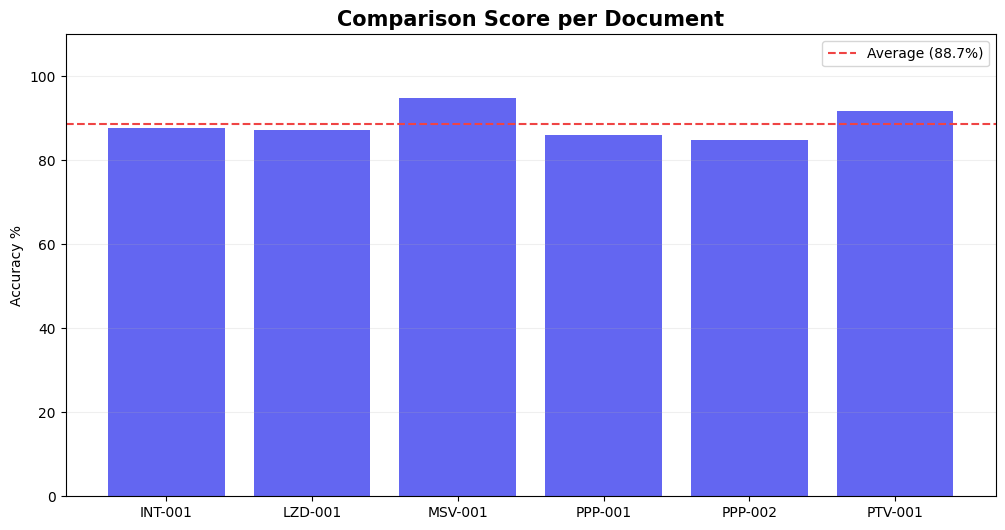

File,Score,Fields
INT-001,87.62%,14
LZD-001,87.11%,13
MSV-001,94.85%,12
PPP-001,86.03%,35
PPP-002,84.89%,23
PTV-001,91.62%,12


In [6]:
# FINAL BATCH SUMMARY
display(HTML("<h1 style='color: #1e293b; margin-top: 40px;'>Batch Processing Final Results</h1>"))

summary_df = pd.DataFrame(batch_summary)

if not summary_df.empty:
    # Aggregate Score
    avg_batch_score = summary_df['Score'].mean()
    
    display(HTML(f"""
    <div style='background: linear-gradient(135deg, #1e293b 0%, #334155 100%); color: white; padding: 30px; border-radius: 15px; margin-bottom: 30px;'>
        <h2 style='margin: 0; opacity: 0.8;'>Aggregate Accuracy</h2>
        <div style='font-size: 48px; font-weight: bold;'>{avg_batch_score:.2f}%</div>
        <div style='margin-top: 10px; font-size: 16px;'>Across {len(summary_df)} documents</div>
    </div>
    """))

    # Plotting Leaderboard
    plt.figure(figsize=(12, 6))
    plt.bar(summary_df['File'], summary_df['Score'], color='#6366f1')
    plt.axhline(y=avg_batch_score, color='#ef4444', linestyle='--', label=f'Average ({avg_batch_score:.1f}%)')
    plt.title("Comparison Score per Document", fontsize=15, fontweight='bold')
    plt.ylabel("Accuracy %")
    plt.ylim(0, 110)
    plt.legend()
    plt.grid(axis='y', alpha=0.2)
    plt.show()

    # Detailed Final Styler
    def final_score_style(val):
        color = '#16a34a' if val > 90 else '#eab308' if val > 75 else '#ef4444'
        return f'color: {color}; font-weight: bold;'

    # Display final results table
    display(HTML("<h3>Document Leaderboard</h3>"))
    display(summary_df.style.map(final_score_style, subset=['Score'])\
                      .format({"Score": "{:.2f}%"})\
                      .set_properties(**{'text-align': 'center', 'padding': '15px'})\
                      .hide(axis='index'))
else:
    print("No results to summarize.")